In [4]:
import pandas as pd
import os

In [3]:
%pwd

'c:\\Users\\KUNAL MEHTA\\Desktop\\Data Science Training\\Projects\\Auto-Insurance-Risk-Profiling\\research'

In [5]:
os.chdir('../')

In [6]:
%pwd

'c:\\Users\\KUNAL MEHTA\\Desktop\\Data Science Training\\Projects\\Auto-Insurance-Risk-Profiling'

In [7]:
potential_customers_2018 = pd.read_csv("artifacts/risk_profiles/risk_profiles.csv")

In [9]:
potential_customers_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7464 entries, 0 to 7463
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   quote_number                  7464 non-null   int64  
 1   gender                        7464 non-null   object 
 2   agecat                        7464 non-null   int64  
 3   date_of_birth                 7464 non-null   object 
 4   credit_score                  7464 non-null   float64
 5   area                          7464 non-null   object 
 6   traffic_index                 7464 non-null   float64
 7   veh_age                       7464 non-null   int64  
 8   veh_body                      7464 non-null   object 
 9   veh_value                     7464 non-null   float64
 10  age                           7464 non-null   int64  
 11  claim_probability             7464 non-null   float64
 12  claim                         7464 non-null   int64  
 13  cla

In [ ]:
from AutoInsurance.utils.common import save_json


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np


Financial_and_regional_features = ['credit_score', 'area', 'traffic_index', 'risk_group']

df = potential_customers_2018[Financial_and_regional_features].copy()

# General Statistics

def analyze_features(df, features):
    result = {}
    
    for feature in features:
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Perform descriptive statistics for numerical columns
            result[feature] = df[feature].describe().to_dict()
        else:
            # Perform frequency counts for categorical columns
            result[feature] = df[feature].value_counts().to_dict()
    
    return result

# Visualizations

def visualize_features(df, features):

    palette = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}
    for feature in features:
        plt.figure(figsize=(12, 6))
        
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Create a box plot for numerical features vs. risk group
            sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)
            plt.title(f'{feature.capitalize()} by Risk Group')
            plt.xlabel('Risk Group')
            plt.ylabel(feature.capitalize())
            plt.show()
        else:
            # Create a bar plot for categorical features vs. risk group
            sns.countplot(x=feature, hue='risk_group', data=df, palette=palette)
            plt.title(f'Risk Group Distribution by {feature.capitalize()}')
            plt.xlabel(feature.capitalize())
            plt.ylabel('Count')
            plt.show()


# Statistical Analysis

def statistical_analysis(df, features):
    results = {}

    for feature in features[:-1]:
        feature_result = {}
        print(f'\nAnalyzing {feature}...')
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Normality Test
            grouped = df.groupby('risk_group')
            normality_p_values = {}
            for name, group in grouped:
                stat, p = stats.shapiro(group[feature])
                normality_p_values[name] = p
                print(f'Normality test for {name} - Statistics={stat:.3f}, p-value={p:.3f}')
                feature_result[f'normality_{name}'] = p
                
            # Homogeneity of variances Test
            groups = [group[feature].dropna() for name, group in grouped]
            stat, p = stats.levene(*groups)
            print(f'Levene’s test for equal variances - Statistics={stat:.3f}, p-value={p:.3f}')
            feature_result['levene_p_value'] = p
            
            if all(p_val > 0.05 for p_val in normality_p_values.values()) and p > 0.05:
                print("Assumptions for ANOVA met, proceeding with ANOVA test.")
                # Perform ANOVA
                anova_stat, anova_p = stats.f_oneway(*groups)
                print(f'ANOVA test result: F-Statistic={anova_stat:.3f}, P-Value={anova_p:.3f}')
                feature_result['anova_p_value'] = anova_p
                
                if anova_p < 0.05:
                    print('ANOVA significant, performing Tukey HSD test...')
                    posthoc = sp.posthoc_tukey_hsd(df[feature], df['risk_group'])
                    print(posthoc)
                    feature_result['tukey_hsd'] = posthoc
                else:
                    print('ANOVA not significant, no further tests required.')
            else:
                print("Assumptions for ANOVA not met, proceeding with Kruskal-Wallis test.")
                # Perform Kruskal-Wallis Test
                k_stat, k_p = stats.kruskal(*groups)
                print(f'Kruskal-Wallis Test result: H-Statistic={k_stat:.3f}, P-Value={k_p:.3f}')
                feature_result['kruskal_wallis_p_value'] = k_p
                
                if k_p < 0.05:
                    print('Kruskal-Wallis significant, performing Dunn’s test...')
                    posthoc = sp.posthoc_dunn(df, val_col=feature, group_col='risk_group', p_adjust='bonferroni')
                    print(posthoc)
                    feature_result['dunn_test'] = posthoc
                else:
                    print('Kruskal-Wallis not significant, no further tests required.')
        
        else:
            # Chi-Square Test
            contingency_table = pd.crosstab(df[feature], df['risk_group'])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            print(f"Chi-Square Statistic: {chi2:.2f}")
            print(f"Degrees of Freedom: {dof}")
            print(f"P-value: {p:.3f}")
            print("Expected Frequencies:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
            feature_result['chi2_p_value'] = p

            if p < 0.05:
                print("Chi-Square test significant, calculating standardized residuals...")
                residuals = (contingency_table - expected) / np.sqrt(expected)
                print("\nStandardized Residuals:\n", residuals)
                feature_result['standardized_residuals'] = residuals
            else:
                print("Chi-Square test not significant, no further tests required.")
        
        results[feature] = feature_result

    return results

D:\anaconda3\MEHTA\AppData\Local\Temp\ipykernel_15536\1809274126.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)


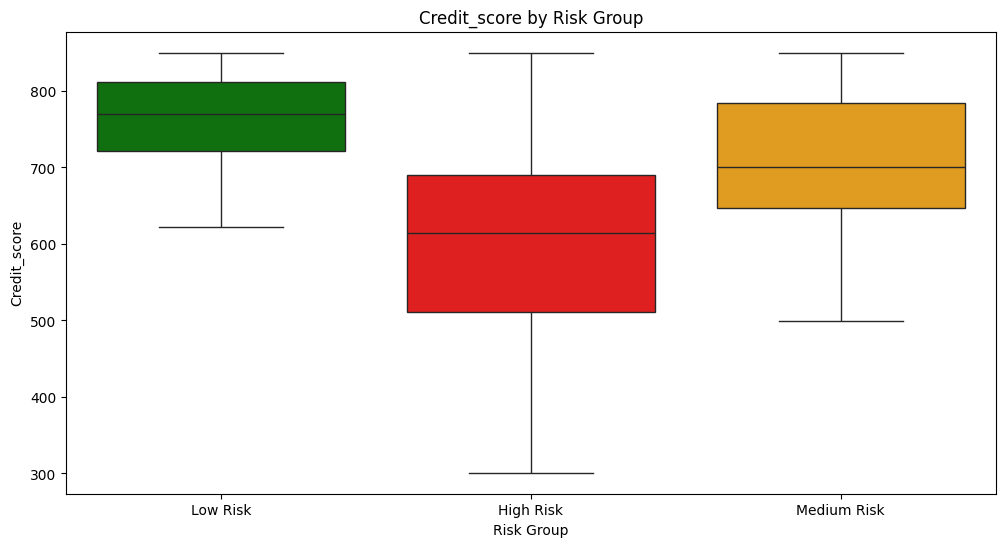

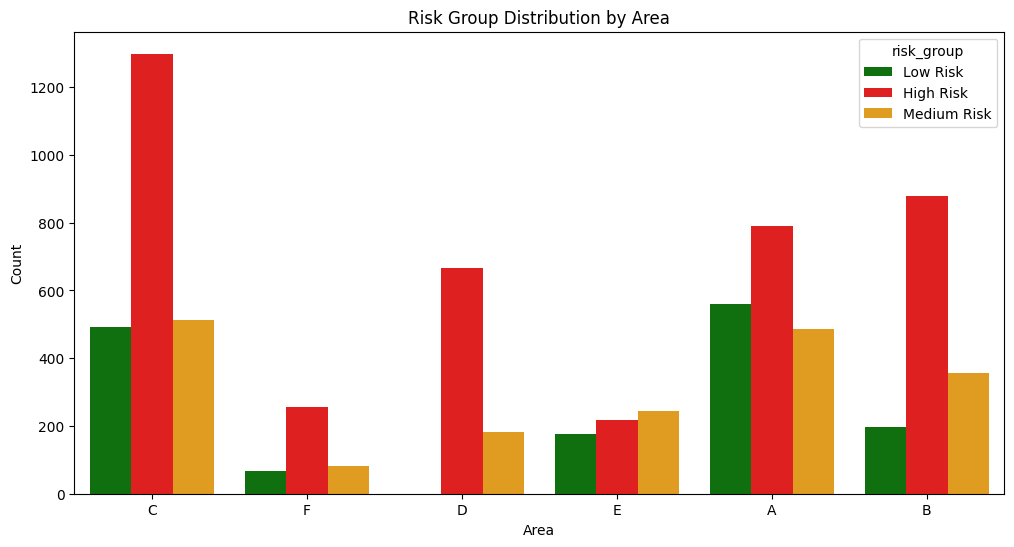

D:\anaconda3\MEHTA\AppData\Local\Temp\ipykernel_15536\1809274126.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)


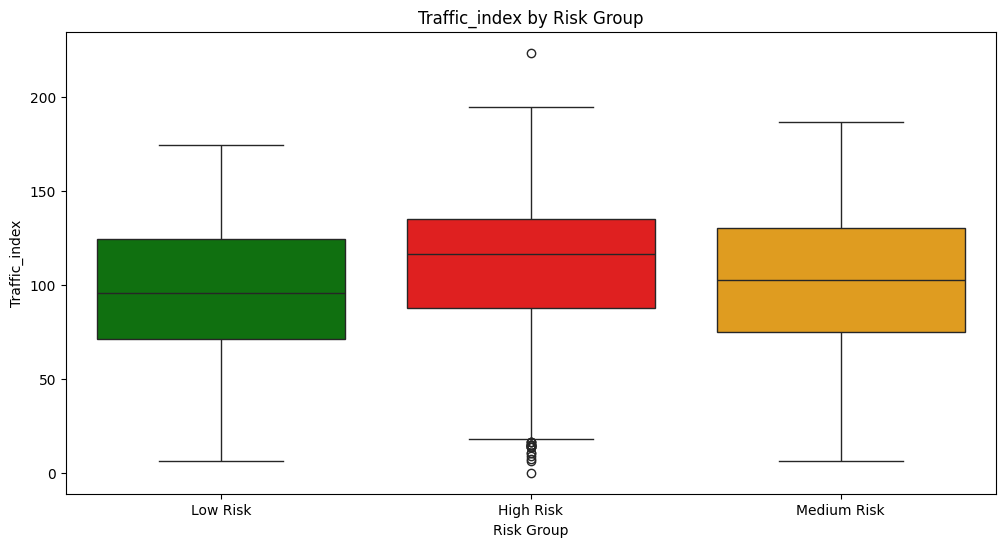

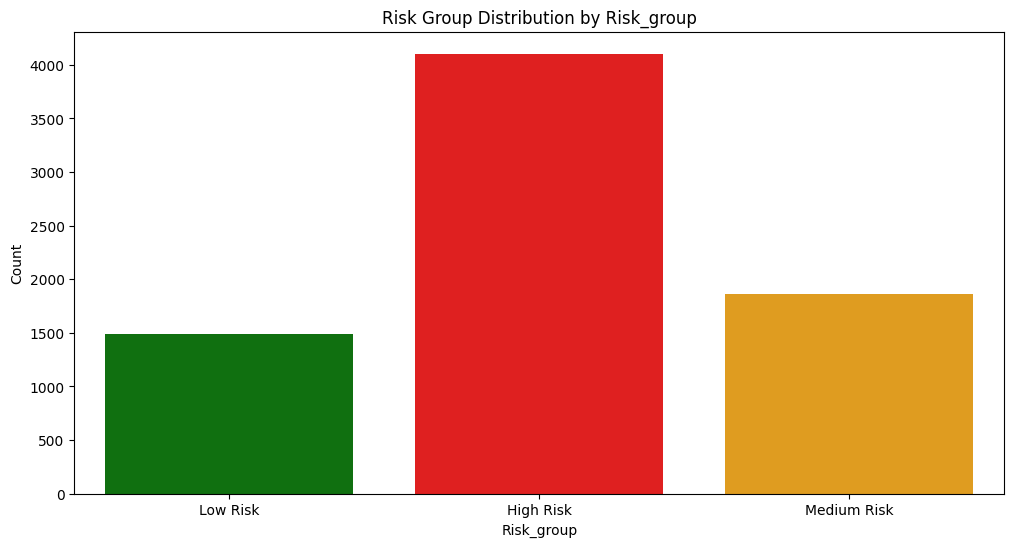


Analyzing credit_score...
Normality test for High Risk - Statistics=0.971, p-value=0.000
Normality test for Low Risk - Statistics=0.956, p-value=0.000
Normality test for Medium Risk - Statistics=0.959, p-value=0.000
Levene’s test for equal variances - Statistics=507.205, p-value=0.000
Assumptions for ANOVA not met, proceeding with Kruskal-Wallis test.
Kruskal-Wallis Test result: H-Statistic=2261.746, P-Value=0.000
Kruskal-Wallis significant, performing Dunn’s test...
                 High Risk      Low Risk    Medium Risk
High Risk     1.000000e+00  0.000000e+00  2.289529e-192
Low Risk      0.000000e+00  1.000000e+00   5.496767e-48
Medium Risk  2.289529e-192  5.496767e-48   1.000000e+00

Analyzing area...
Chi-Square Statistic: 580.02
Degrees of Freedom: 10
P-value: 0.000
Expected Frequencies:
 risk_group    High Risk    Low Risk  Medium Risk
area                                            
A           1009.750804  367.249196       459.00
B            788.111602  286.638398       358.2

{'credit_score': {'normality_High Risk': 5.813763430425109e-28,
  'normality_Low Risk': 1.02514952835292e-20,
  'normality_Medium Risk': 1.3388763474717638e-22,
  'levene_p_value': 2.9231569561446414e-207,
  'kruskal_wallis_p_value': 0.0,
  'dunn_test':                  High Risk      Low Risk    Medium Risk
  High Risk     1.000000e+00  0.000000e+00  2.289529e-192
  Low Risk      0.000000e+00  1.000000e+00   5.496767e-48
  Medium Risk  2.289529e-192  5.496767e-48   1.000000e+00},
 'area': {'chi2_p_value': 3.3606007967020028e-118,
  'standardized_residuals': risk_group  High Risk   Low Risk  Medium Risk
  area                                         
  A           -6.915497  10.005914     1.306928
  B            3.201915  -5.235458    -0.066041
  C            0.895071   1.497053    -2.666667
  D            9.212706 -13.031606    -2.007715
  E           -7.099749   4.236433     6.740938
  F            2.122142  -1.465968    -1.836279},
 'traffic_index': {'normality_High Risk': 7.0333890

In [41]:
analyze_features(df, Financial_and_regional_features)
visualize_features(df, Financial_and_regional_features)
statistical_analysis(df, Financial_and_regional_features)

# Demogrphic Analysis

In [10]:
demographic_features = ['gender', 'agecat', 'risk_group']
Financial_and_regional_features = ['credit_score', 'area', 'traffic_index', 'risk_group']
vehicular_features = ['veh_age','veh_body','veh_value', 'risk_group']

In [31]:
df = potential_customers_2018[demographic_features].copy()

## General statistics

In [14]:
def analyze_features(df, features):
    result = {}
    
    for feature in features:
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Perform descriptive statistics for numerical columns
            result[feature] = df[feature].describe().to_dict()
        else:
            # Perform frequency counts for categorical columns
            result[feature] = df[feature].value_counts().to_dict()
    
    return result

In [15]:
analyze_features(df, Financial_and_regional_features)

{'credit_score': {'count': 7464.0,
  'mean': 659.9109056806002,
  'std': 132.35217787648105,
  'min': 301.0,
  '25%': 604.0,
  '50%': 673.0,
  '75%': 765.0,
  'max': 850.0},
 'area': {'C': 2304, 'A': 1836, 'B': 1433, 'D': 849, 'E': 636, 'F': 406},
 'traffic_index': {'count': 7464.0,
  'mean': 104.27794748124332,
  'std': 33.79759806584123,
  'min': 0.0,
  '25%': 80.7,
  '50%': 109.8,
  '75%': 132.8,
  'max': 223.7},
 'risk_group': {'High Risk': 4105, 'Medium Risk': 1866, 'Low Risk': 1493}}

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
def visualize_features(df, features):

    palette = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}
    for feature in features:
        plt.figure(figsize=(12, 6))
        
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Create a box plot for numerical features vs. risk group
            sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)
            plt.title(f'{feature.capitalize()} by Risk Group')
            plt.xlabel('Risk Group')
            plt.ylabel(feature.capitalize())
            plt.show()
        else:
            # Create a bar plot for categorical features vs. risk group
            sns.countplot(x=feature, hue='risk_group', data=df, palette=palette)
            plt.title(f'Risk Group Distribution by {feature.capitalize()}')
            plt.xlabel(feature.capitalize())
            plt.ylabel('Count')
            plt.show()

D:\anaconda3\MEHTA\AppData\Local\Temp\ipykernel_15536\2655692259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)


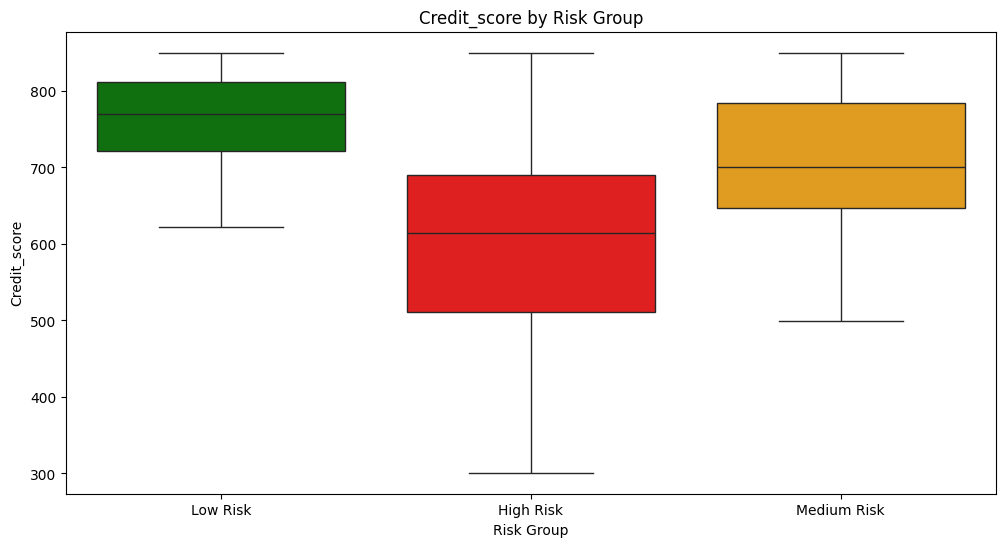

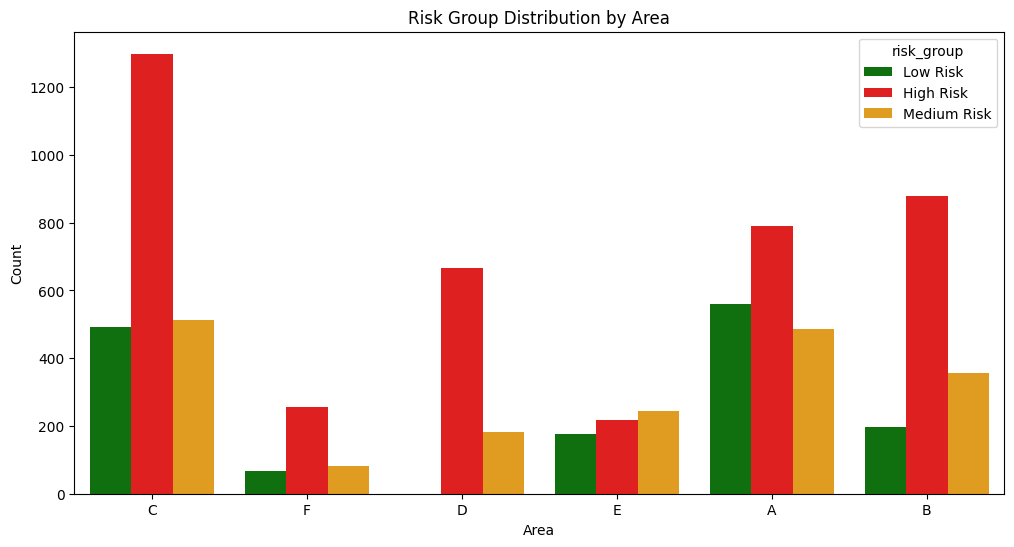

D:\anaconda3\MEHTA\AppData\Local\Temp\ipykernel_15536\2655692259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_group', y=feature, data=df, palette=palette)


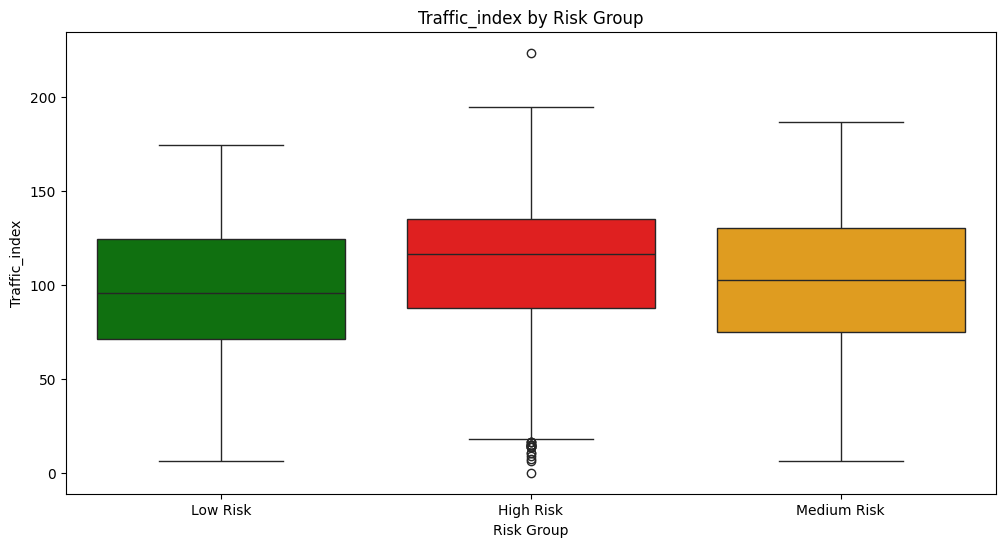

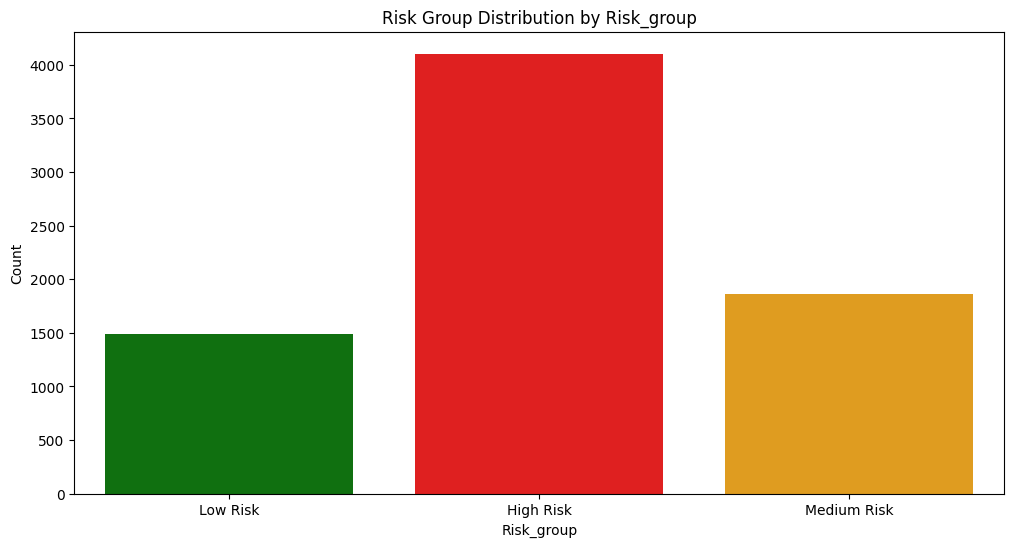

In [24]:
visualize_features(df, Financial_and_regional_features)

In [35]:
def analyze_features(df, features):
    results = {}

    for feature in features[:-1]:
        feature_result = {}
        print(f'\nAnalyzing {feature}...')
        if pd.api.types.is_numeric_dtype(df[feature]):
            # Normality Test
            grouped = df.groupby('risk_group')
            normality_p_values = {}
            for name, group in grouped:
                stat, p = stats.shapiro(group[feature])
                normality_p_values[name] = p
                print(f'Normality test for {name} - Statistics={stat:.3f}, p-value={p:.3f}')
                feature_result[f'normality_{name}'] = p
                
            # Homogeneity of variances Test
            groups = [group[feature].dropna() for name, group in grouped]
            stat, p = stats.levene(*groups)
            print(f'Levene’s test for equal variances - Statistics={stat:.3f}, p-value={p:.3f}')
            feature_result['levene_p_value'] = p
            
            if all(p_val > 0.05 for p_val in normality_p_values.values()) and p > 0.05:
                print("Assumptions for ANOVA met, proceeding with ANOVA test.")
                # Perform ANOVA
                anova_stat, anova_p = stats.f_oneway(*groups)
                print(f'ANOVA test result: F-Statistic={anova_stat:.3f}, P-Value={anova_p:.3f}')
                feature_result['anova_p_value'] = anova_p
                
                if anova_p < 0.05:
                    print('ANOVA significant, performing Tukey HSD test...')
                    posthoc = sp.posthoc_tukey_hsd(df[feature], df['risk_group'])
                    print(posthoc)
                    feature_result['tukey_hsd'] = posthoc
                else:
                    print('ANOVA not significant, no further tests required.')
            else:
                print("Assumptions for ANOVA not met, proceeding with Kruskal-Wallis test.")
                # Perform Kruskal-Wallis Test
                k_stat, k_p = stats.kruskal(*groups)
                print(f'Kruskal-Wallis Test result: H-Statistic={k_stat:.3f}, P-Value={k_p:.3f}')
                feature_result['kruskal_wallis_p_value'] = k_p
                
                if k_p < 0.05:
                    print('Kruskal-Wallis significant, performing Dunn’s test...')
                    posthoc = sp.posthoc_dunn(df, val_col=feature, group_col='risk_group', p_adjust='bonferroni')
                    print(posthoc)
                    feature_result['dunn_test'] = posthoc
                else:
                    print('Kruskal-Wallis not significant, no further tests required.')
        
        else:
            # Chi-Square Test
            contingency_table = pd.crosstab(df[feature], df['risk_group'])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            print(f"Chi-Square Statistic: {chi2:.2f}")
            print(f"Degrees of Freedom: {dof}")
            print(f"P-value: {p:.3f}")
            print("Expected Frequencies:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
            feature_result['chi2_p_value'] = p

            if p < 0.05:
                print("Chi-Square test significant, calculating standardized residuals...")
                residuals = (contingency_table - expected) / np.sqrt(expected)
                print("\nStandardized Residuals:\n", residuals)
                feature_result['standardized_residuals'] = residuals
            else:
                print("Chi-Square test not significant, no further tests required.")
        
        results[feature] = feature_result

    return results




In [36]:
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
results = analyze_features(df, demographic_features)



Analyzing gender...
Chi-Square Statistic: 2278.23
Degrees of Freedom: 2
P-value: 0.000
Expected Frequencies:
 risk_group    High Risk    Low Risk  Medium Risk
gender                                          
F           2357.735129  857.514871      1071.75
M           1747.264871  635.485129       794.25
Chi-Square test significant, calculating standardized residuals...

Standardized Residuals:
 risk_group  High Risk   Low Risk  Medium Risk
gender                                       
F          -19.909483  21.701241    10.118337
M           23.127470 -25.208830   -11.753772

Analyzing agecat...
Normality test for High Risk - Statistics=0.922, p-value=0.000
Normality test for Low Risk - Statistics=0.925, p-value=0.000
Normality test for Medium Risk - Statistics=0.938, p-value=0.000
Levene’s test for equal variances - Statistics=97.002, p-value=0.000
Assumptions for ANOVA not met, proceeding with Kruskal-Wallis test.
Kruskal-Wallis Test result: H-Statistic=311.851, P-Value=0.000
Krusk